In [0]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras import applications
import pandas as pd
import numpy as np

from PIL import Image
import requests
from io import BytesIO
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
dfTracks = pd.read_pickle("C:\\Users\\Devina Parihar\\Desktop\\LIN373Proj\\MusicGenreClassifier_LIN373\\dfTracks.pkl")

In [0]:
len(dfTracks.genres.unique().tolist())

12903

In [0]:
(dfTracks[dfTracks.amazon_id == '1591791065']).genres.tolist()[0]



'New Age,Dance Pop,World Music,Pop,Classical'

In [0]:
dfImages = pd.read_pickle("C:\\Users\\Devina Parihar\\Desktop\\LIN373Proj\\MusicGenreClassifier_LIN373\\df_images.pkl")
dfImages['imUrl'][1]
dfImages['amazonID'][1]


'1591791065'

In [0]:
genres = []

#get genre for each album cover through amazon ID and create new target col
for index, row in dfImages.iterrows():
    idAma = (row['amazonID'])
    genre = (dfTracks[dfTracks.amazon_id == idAma]).genres.tolist()[0]
    genres.append(genre)
    
dfImages["genres"] = genres

NameError: name 'dfImages' is not defined

In [0]:
dfImages = pd.read_pickle("dfImages_withGenres")

In [0]:
dfImages.imUrl.tolist()[0]

'http://ecx.images-amazon.com/images/I/51fdvJLWs5L._SY300_.jpg'

In [0]:
dfSampled = dfImages.sample(n = 1500)

In [0]:
import numpy as np
dfImagesList = np.array_split(dfImages, 11)

In [0]:
dfSampled.imUrl.tolist()[0]

'http://ecx.images-amazon.com/images/I/41p%2BJCV-Q-L._SY300_.jpg'

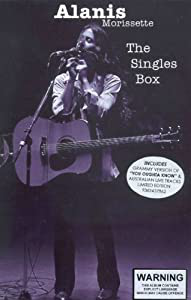

In [0]:
response = requests.get('http://ecx.images-amazon.com/images/I/41p%2BJCV-Q-L._SY300_.jpg')
img = Image.open(BytesIO(response.content))
img

In [0]:
dfSampled

,imUrl,amazonID,genres
9177,http://ecx.images-amazon.com/images/I/41p%2BJC...,B000005S63,"Alternative Rock,Pop"
5325,http://ecx.images-amazon.com/images/I/4131BAQ1...,B000002IS2,"Oldies,Soul,Pop,R&B,Rock,Classic R&B,Blues"
25487,http://ecx.images-amazon.com/images/I/51Nji0P5...,B000KG4BPY,"Alternative Rock,Adult Alternative,Country,Pop..."
827,http://ecx.images-amazon.com/images/I/51ZpIaBw...,B000000DTL,"Jewish & Yiddish,Jazz,World Music,Pop,Folk"
15383,http://ecx.images-amazon.com/images/I/51pT1y23...,B00004XRFY,"Adult Contemporary,R&B,Pop,Adult Alternative,D..."
...,...,...,...
17980,http://ecx.images-amazon.com/images/I/51NTp3yK...,B000067CQI,"Australia & New Zealand,Metal,Pop Metal,Pop,Wo..."
16247,http://ecx.images-amazon.com/images/I/51Q0CYE0...,B00005B58U,"Alternative Rock,Country,Today's Country,Pop,A..."
29364,http://ecx.images-amazon.com/images/I/51NDOXcE...,B002E2LW9K,"Metal,Pop Metal,Pop,Rock"
14281,http://ecx.images-amazon.com/images/I/61P83BsC...,B00003L49Z,"Progressive Rock,Metal,Progressive,Pop,Rock"


In [0]:
def changeToTuple(x):
    stringListGenres = x.split(",")
    stringListGenres = tuple(stringListGenres)
    return(stringListGenres)

In [0]:
img.size

(191, 300)

In [0]:
import time
from PIL import Image, ImageOps


def convertImage(x):
    
    status_code = 'not done'
    
    # x is the image URL
    while(status_code == 'not done'):
        try:
            response = requests.get(x)
            img = Image.open(BytesIO(response.content))

            #resizing code from jdhao's blog
            desired_size = 300
            old_size = img.size  

            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            
            # use thumbnail() or resize() method to resize the input image
            # thumbnail is a in-place operation
            # im.thumbnail(new_size, Image.ANTIALIAS)

            img = img.resize(new_size, Image.ANTIALIAS)
            # create a new image and paste the resized on it

            new_img = Image.new("RGB", (desired_size, desired_size))
            new_img.paste(img, ((desired_size-new_size[0])//2,
                                (desired_size-new_size[1])//2))
            
            
            status_code = 'done'
        except requests.exceptions.ConnectionError:
            time.sleep(5)
            continue

    #PIL format to numpy format(h * w * channels)
    numpy_image = image.img_to_array(new_img)
    numpy_image.shape

    #numpy format to batch format - adds extra dim in (batchsize)
    image_batch = np.expand_dims(numpy_image, axis=0)
    return(image_batch)

In [0]:
X = dfSampled["imUrl"]
X = X.apply(lambda x: convertImage(x))

In [0]:
y = dfSampled["genres"]
y = y.apply(lambda x: changeToTuple(x))

In [0]:
targetList = y.tolist()

In [0]:
X.to_pickle("sample_test_imgsVectorized.pkl")

In [0]:
VecImages = X.to_numpy()

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

targetLabelsBin = mlb.fit_transform(targetList)


In [0]:
targetLabelsBin.shape

(1500, 350)

In [0]:
res = np.array(X.values.tolist()).squeeze()

(300, 300, 3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(res, targetLabelsBin, test_size=0.25, random_state=42)


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

number of training examples = 1125
number of test examples = 375
X_train shape: (1125, 300, 300, 3)
y_train shape: (1125, 350)
X_test shape: (375, 300, 300, 3)
y_test shape: (375, 350)


In [0]:
#img_height,img_width = 300,300
from keras.layers import Input, Dense
img = Input(shape = (300, 300, 3))


base_model = applications.resnet50.ResNet50(weights = 'imagenet',include_top = False, input_tensor = img, input_shape = None, pooling = 'avg')

94658560/94653016 [==============================] - 7s 0us/step


In [0]:
processed_image = preprocess_input(image_batch, mode='caffe')

In [0]:
#model1 = ResNet50(weights = 'imagenet', include_top=False)

In [0]:
processed_image = preprocess_input(image_batch, mode=’caffe’)

In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model
num_classes = 350

#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.7)(x)

#predictions = Dense(num_classes, activation= 'softmax')(x)

#model = Model(inputs = base_model.input, outputs = predictions)

final_layer = base_model.layers[-1].output
dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
output_layer = Dense(350, activation = 'sigmoid')(dense_layer_1)
model = Model(input = img, output = output_layer)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [0]:
from keras.optimizers import SGD, Adam

adam = Adam(lr=0.0001)
model.compile(optimizer = 'adam',metrics = ['accuracy'], loss = 'binary_crossentropy')

In [0]:
model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_test, y_test), validation_freq=5, verbose = 1)

Train on 1125 samples, validate on 375 samples
Epoch 1/20
1125/1125 [==============================] - 725s 644ms/step - loss: 0.2020 - accuracy: 0.9106
Epoch 2/20
1125/1125 [==============================] - 712s 633ms/step - loss: 0.0635 - accuracy: 0.9844
Epoch 3/20
1125/1125 [==============================] - 716s 636ms/step - loss: 0.0623 - accuracy: 0.9844
Epoch 4/20
1125/1125 [==============================] - 732s 651ms/step - loss: 0.0616 - accuracy: 0.9845
Epoch 5/20
1125/1125 [==============================] - 789s 701ms/step - loss: 0.0617 - accuracy: 0.9846 - val_loss: 0.1348 - val_accuracy: 0.9816
Epoch 6/20
1125/1125 [==============================] - 718s 638ms/step - loss: 0.0605 - accuracy: 0.9846
Epoch 7/20
1125/1125 [==============================] - 717s 637ms/step - loss: 0.0600 - accuracy: 0.9846
Epoch 8/20
1125/1125 [==============================] - 719s 639ms/step - loss: 0.0590 - accuracy: 0.9848
Epoch 9/20
1125/1125 [==============================] - 736s 65

In [0]:
model.save("KerasResNetv1.h5")

In [0]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
X_test[23][None]

array([[[[ 93.,  96., 105.],
         [ 90.,  93., 102.],
         [102., 105., 114.],
         ...,
         [ 39.,  36.,  31.],
         [ 40.,  37.,  32.],
         [ 47.,  44.,  39.]],

        [[ 18.,  21.,  30.],
         [ 16.,  19.,  28.],
         [ 16.,  19.,  28.],
         ...,
         [  5.,   2.,   0.],
         [  7.,   4.,   0.],
         [ 15.,  12.,   7.]],

        [[ 22.,  22.,  32.],
         [ 24.,  24.,  34.],
         [ 12.,  12.,  22.],
         ...,
         [  7.,   2.,   0.],
         [  9.,   4.,   0.],
         [ 17.,  12.,   8.]],

        ...,

        [[ 21.,  12.,  17.],
         [ 21.,  12.,  17.],
         [ 22.,  13.,  18.],
         ...,
         [ 14.,   5.,   6.],
         [ 15.,   6.,   7.],
         [ 15.,   6.,   7.]],

        [[ 21.,  12.,  17.],
         [ 21.,  12.,  17.],
         [ 22.,  13.,  18.],
         ...,
         [ 13.,   4.,   5.],
         [ 13.,   4.,   5.],
         [ 14.,   5.,   6.]],

        [[  0.,   0.,   0.],
       

In [0]:
#import keras
preds = model.predict(X_test[20][None])
#y_prob.shape
#y_classes = y_prob.argmax(axis=-1)

preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [0]:
preds[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
result = np.where(preds[0] == 1.)

In [0]:
result

(array([ 78, 268]),)

In [0]:
y_test[20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
result2 = np.where(y_test[20] == 1)
result2

(array([199]),)

MemoryError: 